In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
from BoschUtils import sampled_data_set, general_df, use_cols_list, entire_data_set
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
# 入力ファイルの皆さん

INPUT_FILES = [
#     "../output/reduced_{type}_date_normalized.csv.gz",
#     "../output/{type}_categorical_L3_S32_F3854.csv.gz",
#     "../output/reduced_{type}_numeric.csv.gz",
#     "../output/date_diff_{type}.csv.gz",
    "../output/reduced_{type}_date.csv.gz",
]

TRAINS = []
TESTS = []

for file in INPUT_FILES:
    TRAINS.append(file.format(type="train"))
    TESTS.append(file.format(type="test"))

RESPONSE = "../output/train_response.csv.gz"

In [13]:
%%time
# 全入力データを読み込み
X = sampled_data_set(TRAINS)
y = general_df(RESPONSE).loc[X.index].values.ravel()
X = X.values

../output/reduced_train_date.csv.gz
CPU times: user 10.6 s, sys: 20 ms, total: 10.6 s
Wall time: 10.7 s


In [14]:
%%time
# XGBoost の時間だめう！
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

CPU times: user 13min 28s, sys: 296 ms, total: 13min 28s
Wall time: 1min 6s


[  0   1   3   4   5   7   9  10  15  18  19  21  22  23  24  26  27  39
  44  63  64  65  68  71  72  85  99 102 111 120 122 124 126 127 128 130
 131 132 133 134 135 136 137 140 142 143 156 157 158]


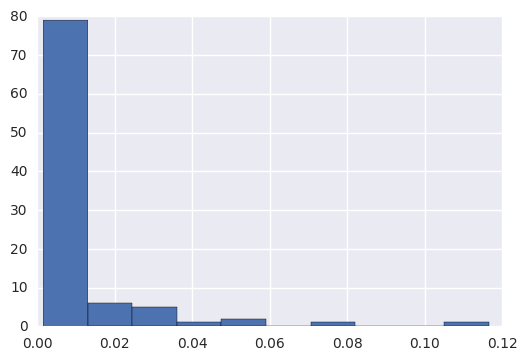

In [15]:
# とりあえず抽出
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_ > 0.005)[0]
print(important_indices)

In [16]:
# 入力データを削減
cols_list = use_cols_list(TRAINS, important_indices)
X = entire_data_set(TRAINS, cols_list)
y = general_df(RESPONSE).values.ravel()

../output/reduced_train_date.csv.gz [  0   1   2   4   5   6   8  10  11  16  19  20  22  23  24  25  27  28
  40  45  64  65  66  69  72  73  86 100 103 112 121 123 125 127 128 129
 131 132 133 134 135 136 137 138 141 143 144 157 158 159]


In [17]:
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.725
fold 1, ROC AUC: 0.700
fold 2, ROC AUC: 0.698
0.707212862461


0.173849046786


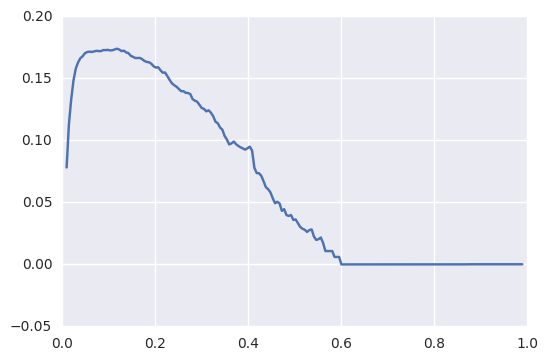

In [18]:
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [19]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_csv("../output/train_response.csv.gz", index_col=0)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,2544,1174324
1.0,857,6022


提出用データを生成する

In [65]:
# テストデータ読み込み
X = entire_data_set(TESTS, cols_list)

# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

# 提出データを生成
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")